# Using Bayesian Inference with Pystan to Make Predictions on CO2 Emsissions
### Erkin Polat

In [ ]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime as dt
import seaborn as sns

In [ ]:
#Loading the data

df = pd.read_csv('weekly_in_situ_co2_mlo.csv', names=['Date', 'CO2'])

In [ ]:
#Inspecting the data

df.head()

,Date,CO2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [ ]:
#Setting the first observation as initial time. I will compute the days after this observation as a time variable

initial_time = dt.strptime(df['Date'][0], "%Y-%m-%d")

In [ ]:
#Creating a days list, and computing the number of days passed between every observation and the initial observation

days = []

for i in range(len(df['Date'])):
  days.append((dt.strptime(df['Date'][i], "%Y-%m-%d") - initial_time).days)

In [ ]:
#Inspecting the general form and seeing the weekly observations

days[:10]

[0, 7, 14, 21, 28, 35, 49, 56, 98, 105]

In [ ]:
#Changing the date strings in the table to date format

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

### The Scenario, Context & Why do we care?
The data at our hands is measurements of the atmospheric carbon dioxide recorded at the Mauna Loa Observatory in Hawaii since 1958. A simple look at the data shows that there is an increasing trend ongoing since the beginning of the observations.



/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'CO2 Levels')

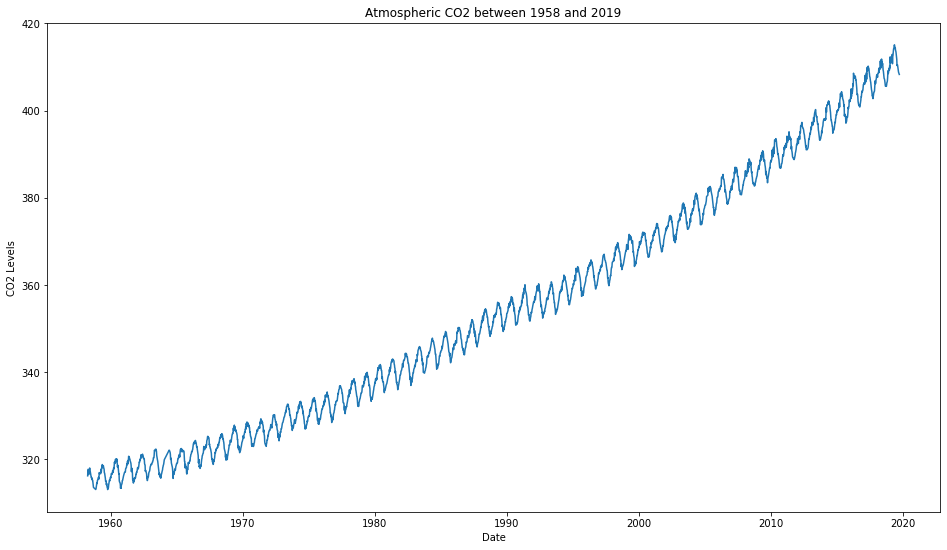

In [ ]:
#Plotting the data to have an idea about the data

plt.figure(figsize=(16, 9))
plt.plot(df['Date'],df['CO2'])
plt.title('Atmospheric CO2 between 1958 and 2019')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')

Even if now the levels of atmospheric CO​2 aren’t at the extremely dangerous levels (it is known that air pollution in some regions in the World might cause health troubles though), the increasing trend is suggestive that at some point, given that we don’t make significant levels in our emission behavior, the atmospheric CO​2 levels would reach a level that is dangerous. A level of 450ppm is identified to be high risk for dangerous climate change.
Our aim here is to make inference about the parameters that shape this trend and generate future data to inspect the potentially upcoming data to 50 years into the future.

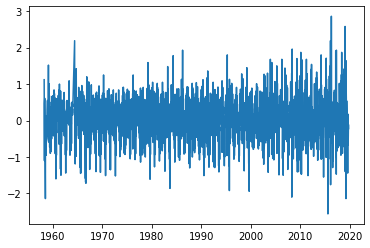

In [ ]:
#Plotting the difference between observations to get an idea about the trend

plt.plot(df['Date'][1:],df['CO2'].diff()[1:])

In [ ]:
#Creating future dates. Observation every week is assumed
#Date in 2058 -- 2058-01-01

future_dates = []

for i in range(0, ((dt.strptime('2058-01-01', "%Y-%m-%d") - initial_time).days - days[-1]), 7):
  future_dates.append(days[-1] + i)

In [ ]:
#Also storing the actual dates for graphing
#We add the number of days into a date and add it on top of the first date

from datetime import timedelta

def get_years(A):
    new_date = df['Date'][0] + timedelta(A - 1)
    return new_date

In [ ]:
#Using the function on the generated future dates

future_dates_actual_date = [get_years(date) for date in future_dates]

### Model Choices

* Long-term trend: quadratic, $\:$$c_0t^2 + c_1t + c_2$ 
<br>----- Even though it looks like the trend could be linear there is a very slight curve in the function that cannot be imitated with a linear function. I'll however, include a linear model too and compare the two.
</br>
* Seasonal variation (every 365¼ days): sine, $\:$$c_3 sin(\frac{2\pi t}{365.25} + c_4)$
<br>----- c4 shifts the period of the sine function
<br>----- c3 influences the height/magnitude of the function
<br>----- I used sine instead of a cos function, because of the position of the data at the starting point. The phase of the data and the cos function doesn’t match and Stan ends up increasing the frequency of the wave to make up for the missed data points.
<br>----- Represents the seasonal variation in the data within a single year
</br>
* Noise: Gaussian with 0 mean and fixed standard deviation, $\:$$c_5$
</br>
* The $c_i$ variables are all unobserved parameters of the model.
</br></br>

Combining these three components gives the following likelihood function:
</br></br>

$p(x_t | \theta) \sim N(c_0t^2 + c_1t + c_2 + c_3 sin(\frac{2\pi t}{365.25} + c_4), c_5)$

<br>
We assume that there indeed is a seasonal trend in the data, however, reading from some other sources I saw claims of 2 month based trends. The seasonal trend is another assumption of the model, which seems to describe the data well.

T in the model represents the time. The model is built so that one period will consist of 365.25 ts. Therefore, days passed since the first observation is used for the value of t.



#### Choosing Priors

My choices for the prior probabilities for the parameters is as follow. I mostly chose uninformed priors. For c2 I was inspecting the data I decided to use a normal distribution centered around 320. This was a realistic place to start since we know we are still below 450ppm at this point. I also checked the internet to learn what is a reasonable CO​2 concentration under normal conditions, so this also gave me a starting point for my prior. Also, I didn’t want my starting point to be too far so that Stan would converge faster, but decided to use a bigger variance so that its influence on the posterior wouldn’t be as big and it would just guide the data.

For the parameters of the quadratic and linear terms I chose normal distributions centered at 0 with a variance of 1. I know the marginal change in such observations with the passing time is low, and probably those parameters aren’t too big either, especially the quadratic term.

For c3 and c4 I didn’t have much information and wanted them to be uninformed and chose cauchy priors because of that. I made sure my defined parameter ranges and the functions ranges match.

c0 ~ Normal(0, 1)<br>
c1 ~ Normal(0, 1)<br>
c2 ~ Normal(320, 100)<br> 
c3 ~ Cauchy(0, 1)<br>
c4 ~ Cauchy(0, 1)<br>
c5 ~ Normal(0, 1)

In [ ]:
updated_model_predictions = """
data {
    int<lower=1> N;                //Number of observations
    real<lower=0> CO2[N];          //measured CO2
    int Days[N];                   //Date values

    int<lower=1> M;                //Number of future observations to be generated
    int Future_Days[M];            //The date values for future observations

}

parameters {
    real<lower=0> c_0;                //Quadratic parameter
    real<lower=0> c_1;                //Linear Parameter
    real<lower=0> c_2;                //Vertical shift parameter
    real<lower=0> c_3;                //Height parameter for the sine wave
    real<lower=0, upper=pi()> c_4;    //Period parameter for the sine wave
    real c_5;                         //Noise

}

model {
    c_0 ~ normal(0,1);
    c_1 ~ normal(0,1);
    c_2 ~ normal(320,100);
    c_3 ~ cauchy(0,1);
    c_4 ~ cauchy(0,1);
    c_5 ~ normal(0,1);

    for(i in 1:N) {                        
      CO2[i] ~ normal(c_0*(Days[i]^2) + c_1*Days[i] + c_2 + c_3*sin((2*pi()*Days[i])/365.25+c_4), c_5);  //likelihood
    }
    
}

generated quantities {
    real<lower=0> predictions[M];

    for(i in 1:M) {                        
      predictions[i] = normal_rng(c_0*(Future_Days[i]^2) + c_1*Future_Days[i] + c_2 + c_3*sin((2*pi()*Future_Days[i])/365.25+c_4), c_5); 
    }

}

"""

In [ ]:
#data to be inputted to the model

data_predict = {
    'N': len(days),
    'M': len(future_dates),
    'CO2': df['CO2'],
    'Days': days,
    'Future_Days': future_dates
}

In [ ]:
#Compiling the model

stan_updated_model_predictions = pystan.StanModel(model_code=updated_model_predictions)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd37fa110b422d9a333d8815d2d8b38c NOW.


In [ ]:
#Fitting the data

stan_results_predict = stan_updated_model_predictions.sampling(data=data_predict)
print(stan_results_predict)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_cd37fa110b422d9a333d8815d2d8b38c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0               9.7e-8 1.8e-11 4.8e-10 9.6e-8 9.7e-8 9.7e-8 9.7e-8 9.8e-8    695    1.0
c_1               2.1e-3  4.2e-7  1.1e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3    704    1.0
c_2               314.57  1.8e-3    0.05 314.46 314.53 314.57 314.61 314.67    951    1.0
c_3                 2.86  3.7e-4    0.02   2.81   2.84   2.86   2.88   2.91   4344    1.0
c_4                 1.15  2.0e-4  8.9e-3   1.14   1.15   1.15   1.16   1.17   1995    1.0
c_5                 0.99  2.2e-4    0.01   0.96   0.98   0.98   0.99   1.01   3155    1.0
predictions[1]    408.21    0.02    0.96 406.29 407.57 408.22 408.86 410.08   4023    1.0
predictions[2]    408.16    0.02    0.99 406.24 407.49 408.18 408.83 410.12   4003    1.0
p

In [ ]:
#Generating samples

new_samples = stan_results_predict.extract()

In [ ]:
#Saving the parameters for the ease of looping

parameters = ['c_0', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5']

### Checking the model convergence

Looking at the autocorrelation and the pair plots, the markov chains converged to each other well and there is no autocorrelation in the data, therefore, we can assume that we covered all of the target distribution.

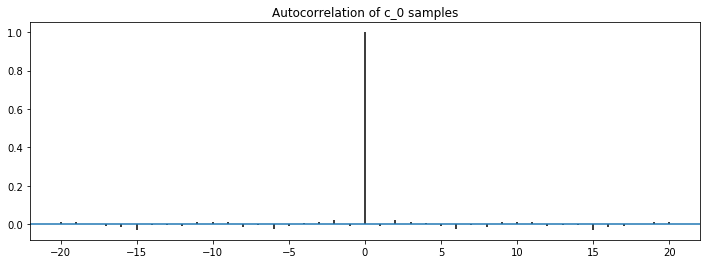

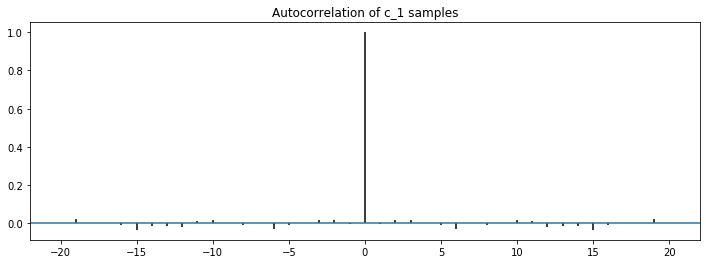

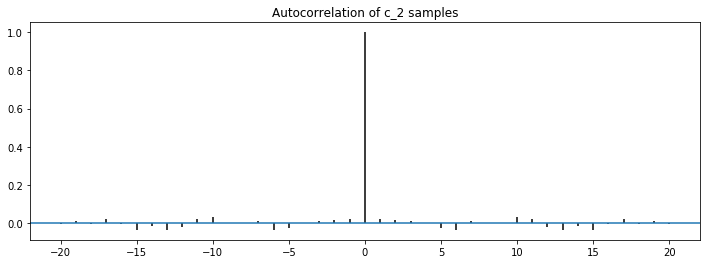

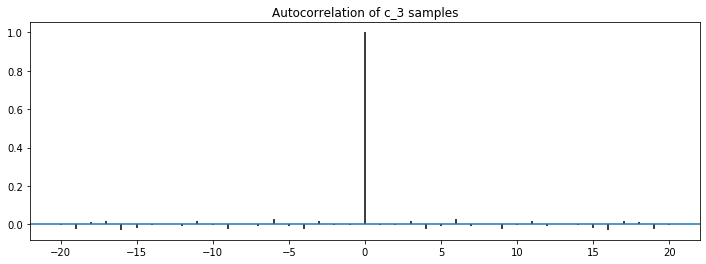

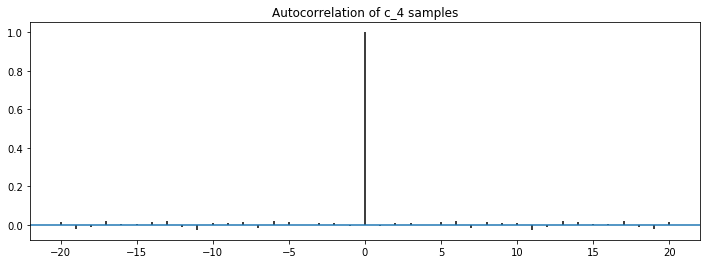

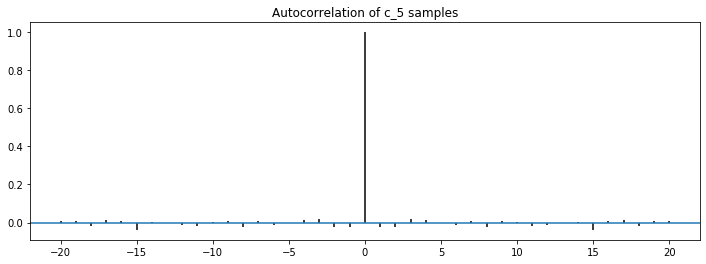

In [ ]:
#Defining an autocorrelation plot function. The one in the preclass work is used

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(new_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

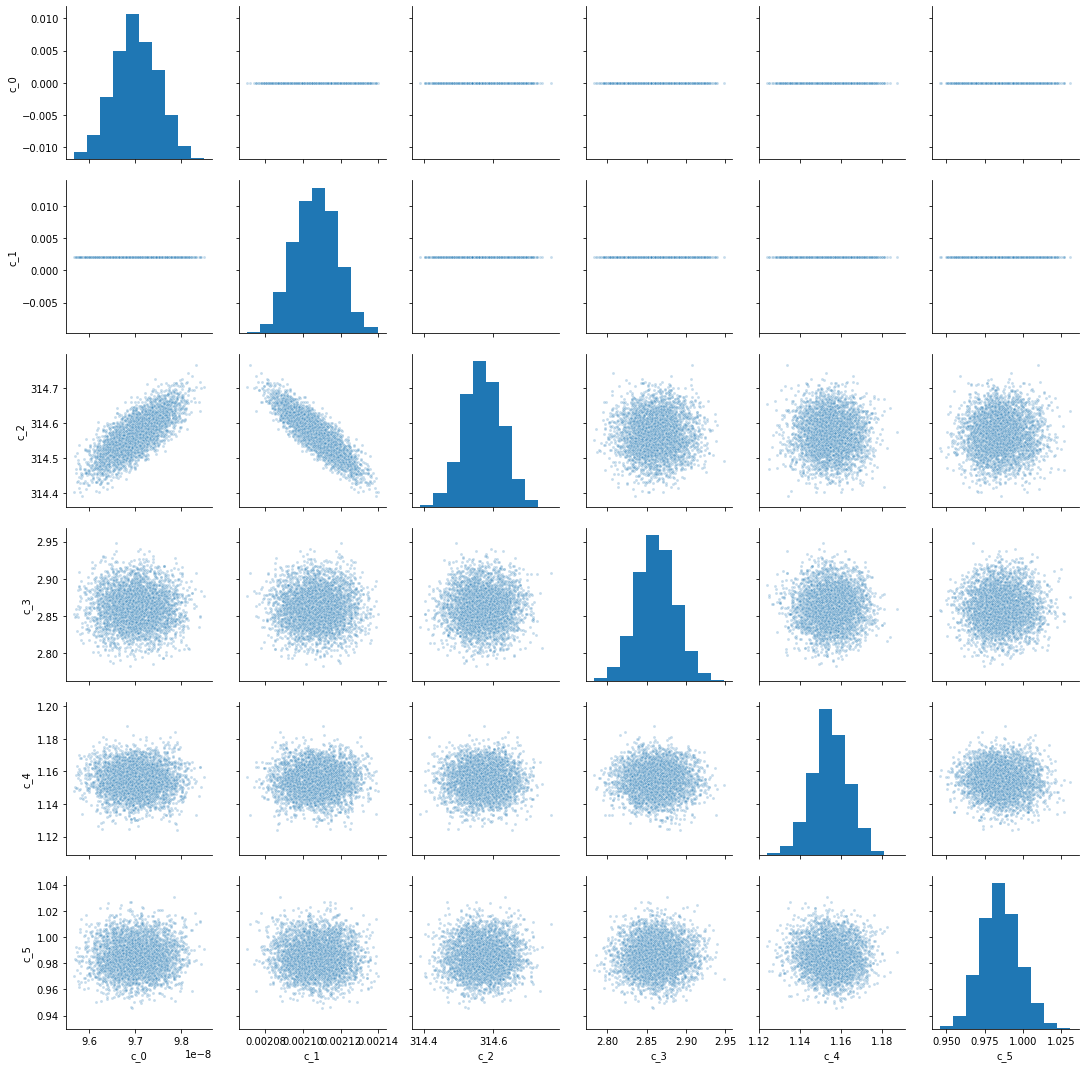

In [ ]:
#Getting the pairplots

param_table = pd.DataFrame(
    data=np.transpose([new_samples[param] for param in parameters]),
    columns=parameters)
sns.pairplot(param_table, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
#Defining a predictor function based on the function used in the likelihood
#The mean value from the samples are used

def get_predictions(p_samples, d):
  pred = []
  for i in range(len(d)):
    pred.append(stats.norm.rvs(np.mean(p_samples['c_0'])*(d[i]**2) + np.mean(p_samples['c_1'])*d[i] 
                    + np.mean(p_samples['c_2']) + np.mean(p_samples['c_3'])*np.sin((2*np.pi*(d[i])/365.25
                                                                                    + np.mean(p_samples['c_4']))), np.mean(p_samples['c_5'])))
  return pred

In [ ]:
#A function to compute the intervals. This was used in the previous model I had which is included at the end of this notebook

def get_predictions_percentile(p_samples, d, p):
  pred = []
  for i in range(len(d)):
    pred.append(stats.norm.rvs(np.percentile(p_samples['c_0'], p)*(d[i]**2) + np.percentile(p_samples['c_1'], p)*d[i] 
                    + np.percentile(p_samples['c_2'], p) + np.percentile(p_samples['c_3'], p)*np.sin((2*np.pi*(d[i])/365.25
                                                                                    + np.percentile(p_samples['c_4'], p))), np.percentile(p_samples['c_5'], p)))
  return pred

In [ ]:
#Getting predictions for the observed data

predict_observed_range = get_predictions(new_samples, days)

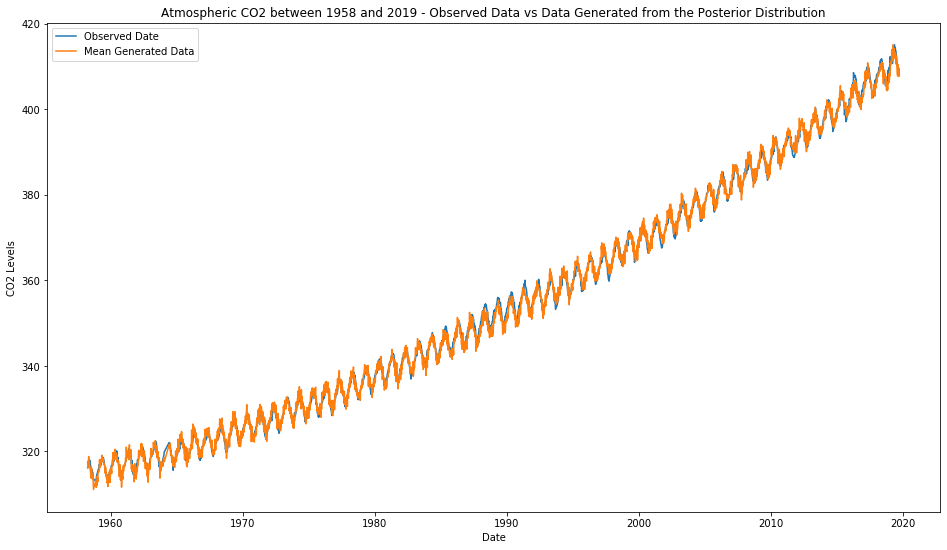

In [ ]:
#Plotting the actual observations and the generated data

plt.figure(figsize = (16,9))
    
plt.plot(df.iloc[:,0],df.iloc[:,1], label='Observed Date')
plt.plot(df.iloc[:,0], predict_observed_range, label='Mean Generated Data')
plt.title('Atmospheric CO2 between 1958 and 2019 - Observed Data vs Data Generated from the Posterior Distribution')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()



In [ ]:
#Defining a residual error function

def get_residual_error(A, B):
  err = []
  for j, k in zip(A, B):
    err.append(j - k)
  return err

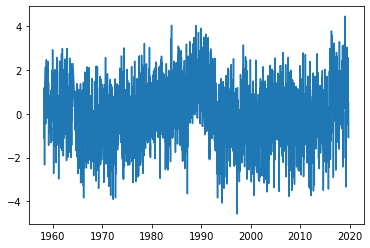

In [ ]:
#Plotting the residual errors. It should be noted that the error is spread out more evenly

plt.plot(df['Date'], get_residual_error(df['CO2'], predict_observed_range))

In [ ]:
#This cell is a copy of some variables from the error section down below I needed this for test statistics too

numpy_days = np.array(days)

test_stat_samples = np.zeros((len(new_samples['c_0']), len(days)))
for i in range(4000):
  test_stat_samples[i, :] =  stats.norm.rvs(new_samples['c_0'][i]*(numpy_days**2) + new_samples['c_1'][i]*numpy_days + new_samples['c_2'][i] + new_samples['c_3'][i]*np.sin(2*np.pi*(numpy_days)/365.25+ new_samples['c_4'][i]), new_samples['c_5'][i])

In [ ]:
#Test Stats
model_mean = []
model_stds = []


#Computing the actual mean and the standard deviation
actual_mean = np.mean(df['CO2'])
actual_std = np.std(df['CO2'])

#Computing the mean and the standard deviation in the generated data
for i in range(4000):
  model_mean.append(np.mean(test_stat_samples[i, :]))
  model_stds.append(np.std(test_stat_samples[i, :]))


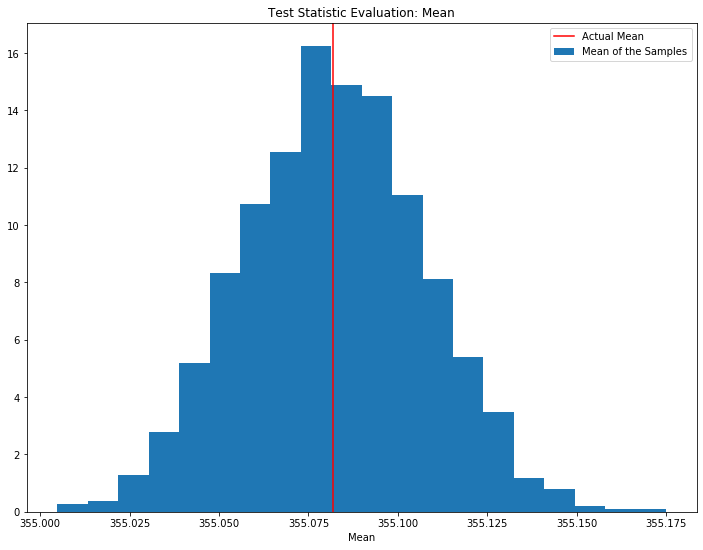

In [ ]:
plt.figure(figsize=(12, 9))
plt.hist(model_mean, bins=20, label='Mean of the Samples', density=True)
plt.axvline(x=actual_mean, color='red', linestyle='-', label='Actual Mean')
plt.legend()
plt.xlabel('Mean')
plt.title('Test Statistic Evaluation: Mean')
plt.show()

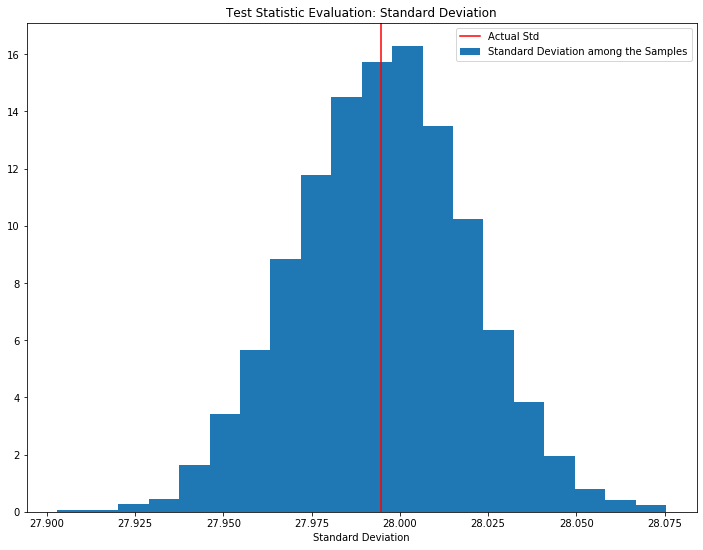

In [ ]:
plt.figure(figsize=(12, 9))
plt.hist(model_stds, bins=20, label='Standard Deviation among the Samples', density=True)
plt.axvline(x=actual_std, color='red', linestyle='-', label='Actual Std')
plt.legend()
plt.xlabel('Standard Deviation')
plt.title('Test Statistic Evaluation: Standard Deviation')
plt.show()

## Implementing a Simpler Linear Model for Comparison

In [ ]:
#Linear model with cosine

example_model_from_the_assignment_description_code = """
data {
    int<lower=1> N;             //Number of observations
    real<lower=0> CO2[N];       //Measurements
    int Days[N];                //Dates of the measurements

}

parameters {       
    real<lower=0> c_1;                 //Linear parameter
    real<lower=0> c_2;                 //Vertical Shift
    real<lower=0> c_3;                 //Height parameter for cosine
    real<lower=0, upper=pi()> c_4;     //Period parameter
    real c_5;                          //Noise

}

model {
    c_1 ~ normal(0,1);
    c_2 ~ normal(320,100);
    c_3 ~ cauchy(0,1);
    c_4 ~ cauchy(0,1);
    c_5 ~ normal(0,1);

    for(i in 1:N) {                        
      CO2[i] ~ normal(c_1*Days[i] + c_2 + c_3*cos((2*pi()*Days[i])/365.25+c_4), c_5);  //likelihood
    }
    
}

"""

In [ ]:
#Defining the data

data = {
    'N': len(days),
    'CO2': df['CO2'],
    'Days': days
}

In [ ]:
#Compiling the model

example_model = pystan.StanModel(model_code=example_model_from_the_assignment_description_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f53a2ac32ff5f8f00c13aa77f0cbf98d NOW.


In [ ]:
#Fitting the data

stan_results_example = example_model.sampling(data=data)
print(stan_results_example)

Inference for Stan model: anon_model_f53a2ac32ff5f8f00c13aa77f0cbf98d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_1  4.3e-3  1.8e-7 1.1e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   3638    1.0
c_2  306.08  2.4e-3   0.14  305.8 305.99 306.08 306.18 306.37   3568    1.0
c_3    2.62  2.0e-3    0.1   2.42   2.55   2.62   2.68   2.81   2282    1.0
c_4  2.8e-3  5.2e-5 2.9e-3 6.2e-5 7.6e-4 1.9e-3 3.9e-3   0.01   3208    1.0
c_5    3.84  1.1e-3   0.05   3.75   3.81   3.84   3.87   3.93   1956    1.0
lp__  -5812    0.04   1.63  -5816  -5813  -5812  -5811  -5810   1362    1.0

Samples were drawn using NUTS at Fri Dec 20 15:59:27 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
#Getting samples

samples_example = stan_results_example.extract()

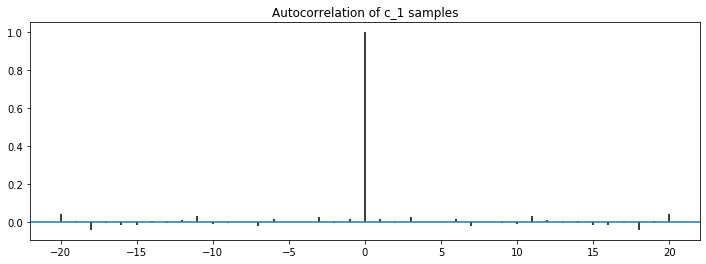

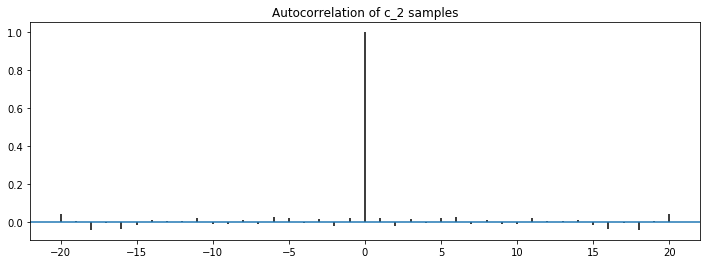

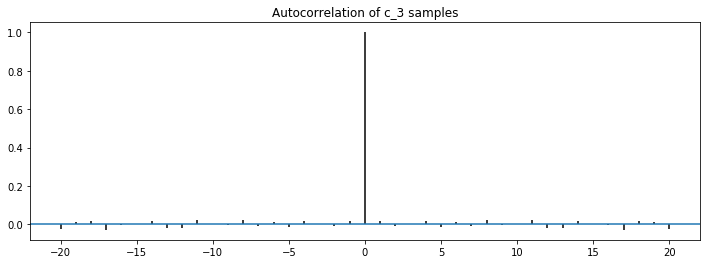

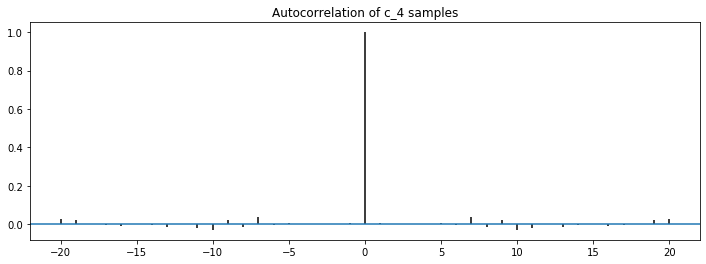

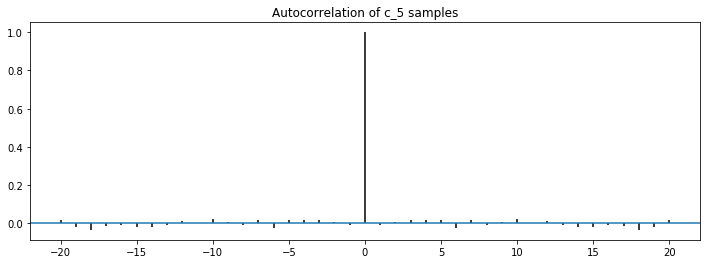

In [ ]:
#Getting the autocorreltaion plots

parameters_example = ['c_1', 'c_2', 'c_3', 'c_4', 'c_5']

for param in parameters_example:
    plt.figure(figsize=(12, 4))
    plot_acf(samples_example[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

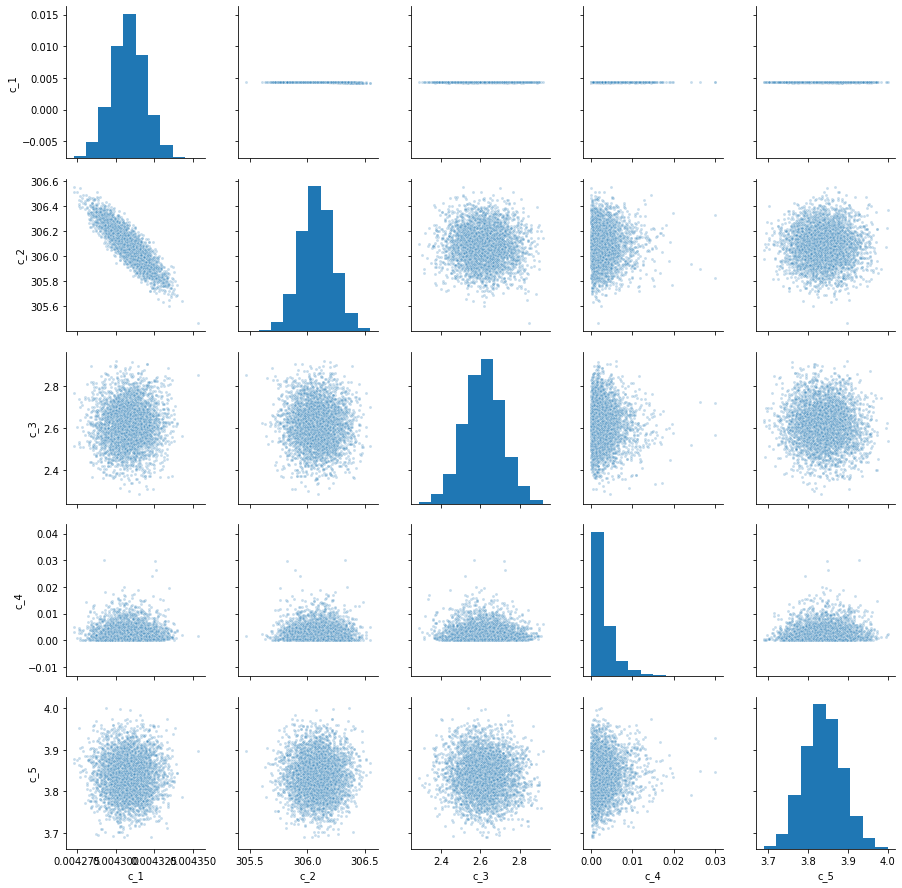

In [ ]:
#Plotting the pairplots

param_table_example = pd.DataFrame(
    data=np.transpose([samples_example[param] for param in parameters_example]),
    columns=parameters_example)
sns.pairplot(param_table_example, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
#Defining a prediction function based on the model

def get_predictions_example(p_samples, d):
  pred = []
  for i in range(len(d)):
    pred.append(stats.norm.rvs(np.mean(p_samples['c_1'])*d[i] 
                    + np.mean(p_samples['c_2']) + np.mean(p_samples['c_3'])*np.cos((2*np.pi*(d[i])/365.25
                                                                                    + np.mean(p_samples['c_4']))), np.mean(p_samples['c_5'])))
  return pred

In [ ]:
#Getting Predictions from the Example Model

observed_predictions_example = get_predictions_example(samples_example, days)

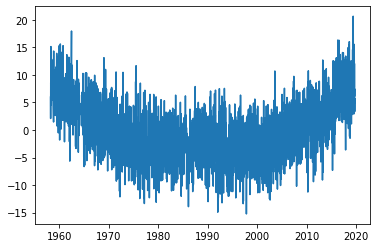

In [ ]:
#Plotting the residual errors. Note that the error is high and the shape of the graph indicates the
#it is not evenly spread. This means that the assumed functional form doesn't fit the actual data.

plt.plot(df['Date'], get_residual_error(df['CO2'], observed_predictions_example))

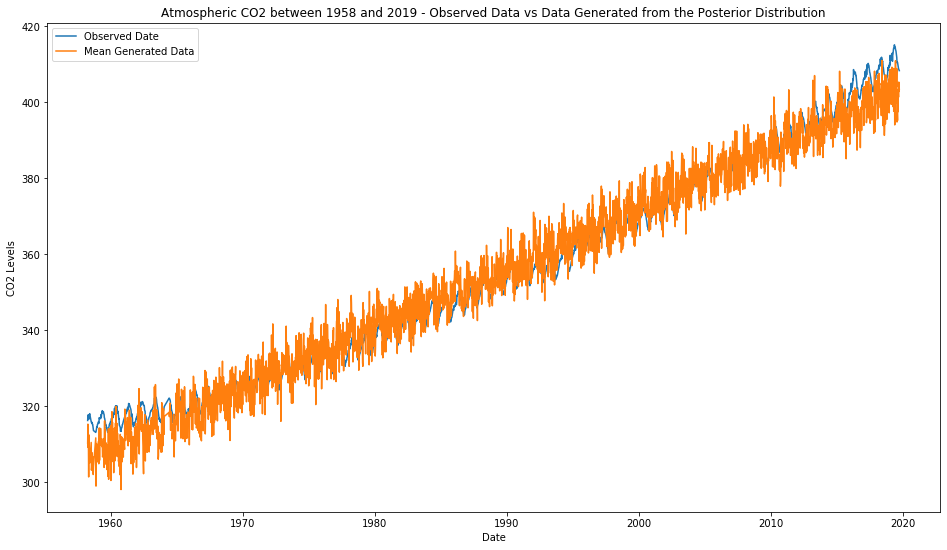

In [ ]:
#Making predictions for the observed data

plt.figure(figsize = (16,9))
    
plt.plot(df.iloc[:,0],df.iloc[:,1], label='Observed Date')
plt.plot(df.iloc[:,0], observed_predictions_example, label='Mean Generated Data')
plt.title('Atmospheric CO2 between 1958 and 2019 - Observed Data vs Data Generated from the Posterior Distribution')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

In [ ]:
#Converting days to numpy so that I can do matrix product

numpy_days = np.array(days)

In [ ]:
#Multiple samples of the function for testing different sample groups

example_test_stat_samples = np.zeros((len(samples_example['c_1']), len(days)))

test_stat_samples = np.zeros((len(new_samples['c_0']), len(days)))

for i in range(4000):
  example_test_stat_samples[i, :] =  stats.norm.rvs(samples_example['c_1'][i]*numpy_days + samples_example['c_2'][i] + samples_example['c_3'][i]*np.cos(2*np.pi*(numpy_days)/365.25+ samples_example['c_4'][i]), samples_example['c_5'][i])

for i in range(4000):
  test_stat_samples[i, :] =  stats.norm.rvs(new_samples['c_0'][i]*(numpy_days**2) + new_samples['c_1'][i]*numpy_days + new_samples['c_2'][i] + new_samples['c_3'][i]*np.sin(2*np.pi*(numpy_days)/365.25+ new_samples['c_4'][i]), new_samples['c_5'][i])


In [ ]:
#For single posterior predictive samples calculating the mean absolute error

#Errors
example_error = []
model_error = []

for i in range(4000):
  example_error.append(np.mean(np.abs(get_residual_error(df['CO2'], example_test_stat_samples[i, :]))))
  model_error.append(np.mean(np.abs(get_residual_error(df['CO2'], test_stat_samples[i, :]))))


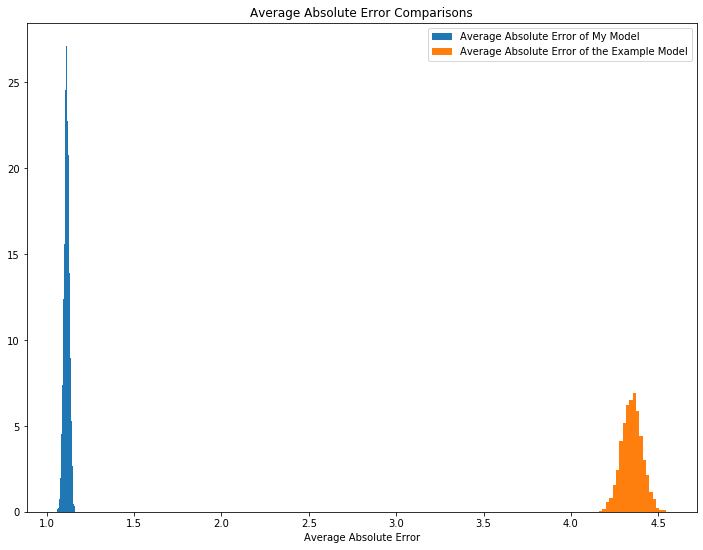

In [ ]:
#Plotting the errors as a histogram

plt.figure(figsize=(12, 9))
plt.hist(model_error, bins=20, label='Average Absolute Error of My Model', density=True)
plt.hist(example_error, bins=20, label='Average Absolute Error of the Example Model', density=True)
plt.legend()
plt.xlabel('Average Absolute Error')
plt.title('Average Absolute Error Comparisons')
plt.show()

## Making Future Predictions with the Improved Model

In [ ]:
#Gettign the predicted values

predp = new_samples['predictions']

In [ ]:
#I realized I don't like the format that Stan automaticall gives these samples. Therefore, Ifind the mean and percentiles
#for the samples for every predicted time point

new_samples['predictions']

mean_predictions = [np.mean(stan_results_predict['predictions['+ str(i)+ ']']) for i in range(1, 1998)]
predictions_025 = [np.percentile(stan_results_predict['predictions['+ str(i)+ ']'], 2.5) for i in range(1, 1998)]
predictions_975 = [np.percentile(stan_results_predict['predictions['+ str(i)+ ']'], 97.5) for i in range(1, 1998)]

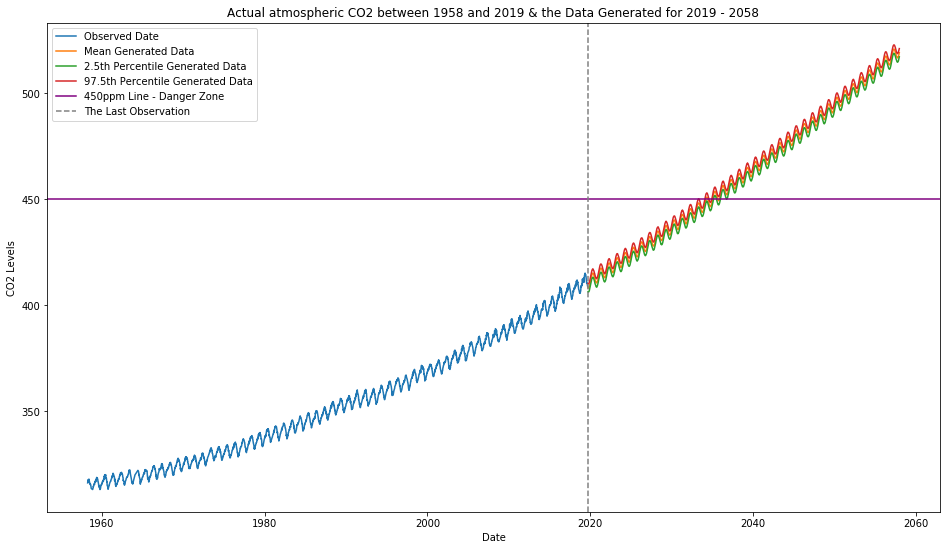

In [ ]:
#Plotting the predictions

plt.figure(figsize = (16,9))
    
plt.plot(df['Date'],df.iloc[:,1], label='Observed Date')
plt.plot(future_dates_actual_date, mean_predictions, label='Mean Generated Data')
plt.plot(future_dates_actual_date, predictions_025, label='2.5th Percentile Generated Data')
plt.plot(future_dates_actual_date, predictions_975, label='97.5th Percentile Generated Data')
plt.axhline(y=450, color='purple', linestyle='-', label='450ppm Line - Danger Zone')
plt.axvline(x=future_dates_actual_date[0], color='grey', linestyle='--', label='The Last Observation')
plt.title('Actual atmospheric CO2 between 1958 and 2019 & the Data Generated for 2019 - 2058')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

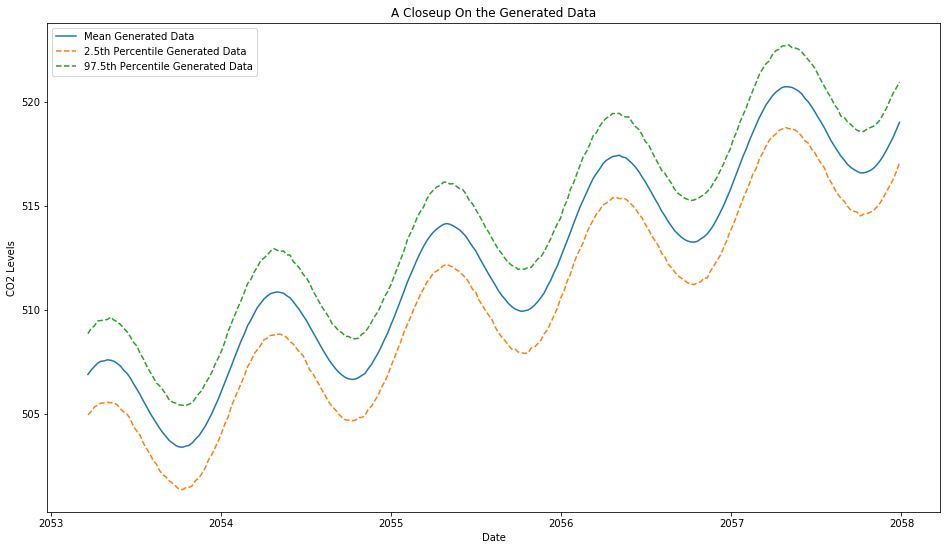

In [ ]:
#Zooming in to the predictions

plt.figure(figsize = (16,9))
    
plt.plot(future_dates_actual_date[-250:], mean_predictions[-250:], label='Mean Generated Data')
plt.plot(future_dates_actual_date[-250:], predictions_025[-250:], label='2.5th Percentile Generated Data', linestyle='--')
plt.plot(future_dates_actual_date[-250:], predictions_975[-250:], label='97.5th Percentile Generated Data', linestyle='--')
plt.title('A Closeup On the Generated Data')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

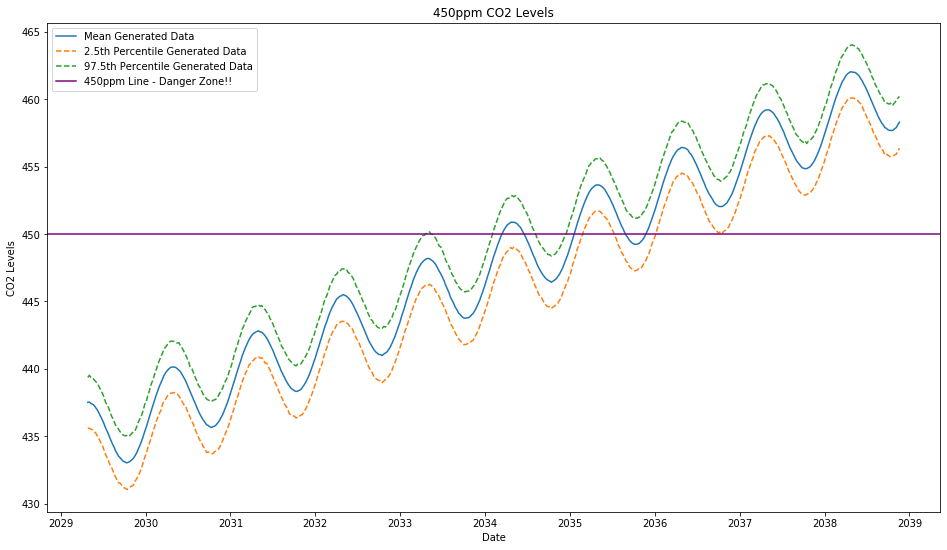

In [ ]:
#Zooming in where 450ppm will be exceeded

plt.figure(figsize = (16,9))
    
plt.plot(future_dates_actual_date[500:1000], mean_predictions[500:1000], label='Mean Generated Data')
plt.plot(future_dates_actual_date[500:1000], predictions_025[500:1000], label='2.5th Percentile Generated Data', linestyle='--')
plt.plot(future_dates_actual_date[500:1000], predictions_975[500:1000], label='97.5th Percentile Generated Data', linestyle='--')
plt.axhline(y=450, color='purple', linestyle='-', label='450ppm Line - Danger Zone!!')
plt.title('450ppm CO2 Levels')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

In [ ]:
#Computing the mean and the percentile values that exceeds 450ppm for the first time

#Writing a function that returns the index when the given amount is passed

def find_dangerous_amount(A, amount):
  for i in range(len(A)):
    if A[i] >= amount:
      return i

print('The mean predictions is predicted to exceed the dangerous levels in ' + dt.strftime(future_dates_actual_date[find_dangerous_amount(mean_predictions, 450)], "%Y-%m-%d"))
print('The 97.5th percentile predictions is predicted to exceed the dangerous levels in ' + dt.strftime(future_dates_actual_date[find_dangerous_amount(predictions_975, 450)], "%Y-%m-%d"))
print('The 2.5th percentile predictions is predicted to exceed the dangerous levels in ' + dt.strftime(future_dates_actual_date[find_dangerous_amount(predictions_025, 450)], "%Y-%m-%d"))

The mean predictions is predicted to exceed the dangerous levels in 2034-03-17
The 97.5th percentile predictions is predicted to exceed the dangerous levels in 2033-04-22
The 2.5th percentile predictions is predicted to exceed the dangerous levels in 2035-03-02


In [ ]:
#Predictions for the beginning of 2058

print('The mean predictions for ' + dt.strftime(future_dates_actual_date[-1], "%Y-%m-%d") + ' is ' + str(mean_predictions[-1]))
print('The 97.5th percentile predictions for ' + dt.strftime(future_dates_actual_date[-1], "%Y-%m-%d") + ' is ' + str(predictions_975[-1]))
print('The 2.5th percentile predictions for ' + dt.strftime(future_dates_actual_date[-1], "%Y-%m-%d") + ' is ' + str(predictions_025[-1]))

The mean predictions for 2057-12-28 is 519.0163229333673
The 97.5th percentile predictions for 2057-12-28 is 520.9554552995927
The 2.5th percentile predictions for 2057-12-28 is 517.0726197451802


### Findings

Sadly, looking at the generated data, the passing of the 450ppm levels are soon. I computed the year of the passing for the mean function and the 95% confidence intervals. These are my findings:
<br>The mean predictions is predicted to exceed the dangerous levels in 2034-03-17
<br>The 97.5th percentile predictions is predicted to exceed the dangerous levels in 2033-04-15 
<br>The 2.5th percentile predictions is predicted to exceed the dangerous levels in 2035-03-02
<br>

This suggests that it is very likely that it is very likely for the dangerous levels to be reached somewhere from 2033-04-15 to 2035-03-02, with 2034-03-17 being the most probable time to reach the 450ppm level.

#### Predictions for the Beginning of 2058

Looking at the predictions below for the end of 2057, we can see that at that time the CO​2 levels will be well above the dangerous amount. And it is very likely that this will have a huge affect on climate change as well as a direct impact on human health in the longer term. We need to reduce our emissions!!

The mean predictions for 2057-12-28 is 519.0163229333673<br>
The 97.5th percentile predictions for 2057-12-28 is 520.9554552995927 
<br>The 2.5th percentile predictions for 2057-12-28 is 517.0726197451802

Maybe even the concentration 50 years later won’t be enough to create instant changes. But we have to note that we identified that this change is happening with a quadratic trend. This means every day we don’t do anything about this, the amount of increase is also increasing, and every day that passes by a comeback is becoming harder and harder.